### A high resolution signal consists of 4096 points out of which 256 measurements are randomly chosen (see Q5xvsy.txt). Using compressed sensing matching pursuit method estimate the dominant signal frequencies, phase-lag, and amplitudes of individual signals which are superimposed.

In [1]:
import numpy as np
# Modified the text file for easy extraction of data
# Open the text file and read its contents
with open('Q5xvsy.txt', 'r') as file:
    data = file.read()

# Remove square brackets and split the data into individual elements
data = data.replace('[', '').replace(']', '').split()

# Convert the list of strings into a numpy array
numpy_array = np.array(data, dtype=float)

In [2]:
x = numpy_array[0:256]
y = numpy_array[256:512]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..','Midsem_2023'))
from cosamp_fn import cosamp

In [4]:
n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)

In [5]:
xnew = x*4096

In [6]:
np.round(xnew, 0)
xnew = np.asarray(xnew, dtype = 'int')

In [7]:
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[xnew,:]       # Measure rows of Psi

In [8]:
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [9]:
s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
xrecon = idct(s) # reconstruct full signal

/var/folders/j5/1syl69yx07zcw3xqdkq8mgrm0000gn/T/ipykernel_37239/1979200982.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b[omega], _, _, _ = np.linalg.lstsq(phiT, u)


In [10]:
print(np.shape(xrecon))

(4096,)


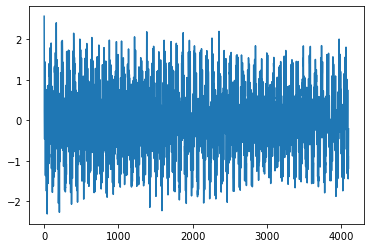

In [11]:
plt.plot(xrecon)
plt.show()

## Applying FFT to determine the dominant frequencies

In [62]:
n = len(xrecon)
fhat = np.fft.fft(xrecon,n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
L = np.arange(1,np.floor(n/8),dtype='int') # Only plot the first half of freqs

/Users/venkatasaisarangrandhe/miniforge3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


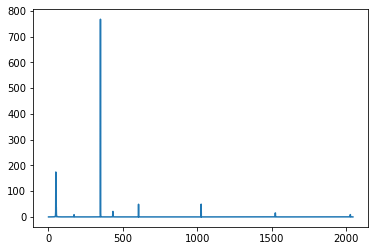

In [48]:
freq = (1/(1/4096*n)) * np.arange(n) 
plt.plot(freq[L], PSD[L])
plt.show()

In [49]:
k = PSD[L]>600

In [50]:
ans = k*PSD[L]

In [51]:
np.sum(ans)

(767.5582687574425+0j)

In [52]:
k=PSD[0:250]>150
ans = k*PSD[0:250]
print(np.sum(ans))

(174.4003492466877+0j)


In [53]:
itemindex = np.where(PSD == 767.5582687574425+0j)
print(itemindex)

(array([ 350, 3746]),)


In [54]:
itemindex = np.where(PSD == 174.4003492466877+0j)
print(itemindex)

(array([  50, 4046]),)


### Therefore the dominant frequencies are 50 and 350. 

For Frequency 350

In [55]:
indices = PSD > 700       # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

/Users/venkatasaisarangrandhe/miniforge3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


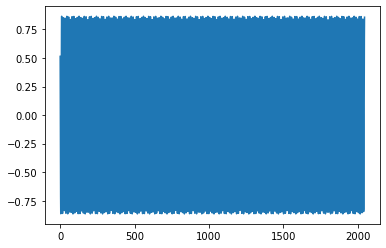

In [56]:
plt.plot(ffilt[L])
plt.show()

In [57]:
np.max(ffilt) 

(0.8657758361880389+0j)

For Frequency 50

In [64]:
# indices = PSD > 100      # Find all freqs with large power
# indice = PSD < 500
PSDclean = np.zeros(4096, dtype = 'complex')
PSDclean[50]= 174.4003492466877+0j
# PSDclean = PSD * indices*indice  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

In [65]:
print(indices)

[False False False ... False False False]


In [66]:
print(ffilt)

[0.79817696+0.j 0.51433664+0.j 0.08576386+0.j ... 0.30329125+0.j
 0.67537645+0.j 0.85741318+0.j]


/Users/venkatasaisarangrandhe/miniforge3/envs/tensorflow/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


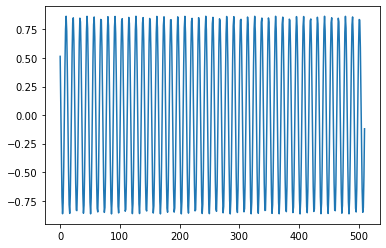

In [67]:
plt.plot(ffilt[L])
plt.show()

In [68]:
np.max(ffilt) 

(0.8657758361880389+0j)

0.8657758361880389+0j is the amplitude of both the frequency signals